<a href="https://colab.research.google.com/github/AnantasiiaAleks/A-B_tests/blob/main/Bands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

Пусть помимо того, что мы хотим экономить время на тестировании и сразу получать эффект от лучшего кандидата, мы еще и хотим подстраиватьсяпод меняющиеся предпочтения пользователей.

Проведем симуляционный эксперимент. Допустим, у нас все те же пять вариаций кнопки, но со временем предпочтения пользователей плавно меняются. В принципе, динамика уже сразу исключает применение одного А/В/n-теста, вот и ладушки.

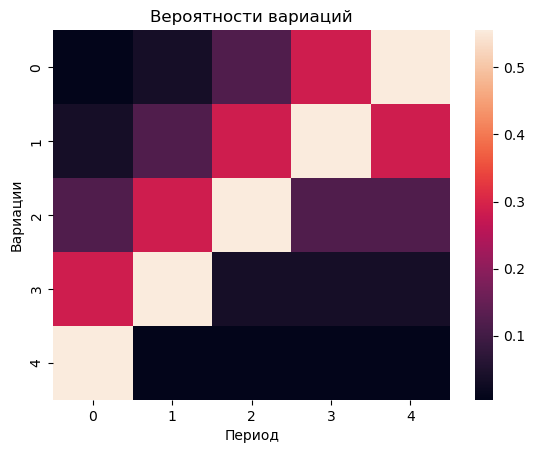

In [ ]:
# количество вариаций (виды баннеров)
n_variations = 5

# сколько раз меняются предпочтения
n_switches = 5

# каждые n_period_len показов кнопки предпочтения у пользователей меняются
n_period_len = 2000

# истинные вероятности клика по каждой вариации
# длина периода, в течение корого тренд не меняется, равна n_period_len
p_true_periods = np.array([
    [1, 2, 3, 4, 5],
    [2, 3, 4, 5, 1],
    [3, 4, 5, 2, 1],
    [4, 5, 3, 2, 1],
    [5, 4, 3, 2, 1]], dtype=np.float32).T**3
p_true_periods /= p_true_periods.sum(axis=0)

# отрисуем истинные вероятности
ax = sns.heatmap(p_true_periods)
ax.set(xlabel='Период', ylabel='Вариации', title='Вероятности вариаций')
plt.show()

Теперь запустим симуляцию: будем выводить после каждого периода наши оценки вероятности клика по каждой вариации и убедимся, что к концу каждого периода находится оптимальная вариация. Также будем следить за тем, сколько трафика из n_period_len отправлено на каждую вариацию.

Договоримся, что каждый график на изображении - это распределение наших ожиданий относительно качества баннера (конверсии вариации). Чем шире график, тем больше неопределенности (прямая линия/равномерное распределение - это полная неопределенность); чем уже, тем меньше неопределенности.

- В первый период мы четко определеяем победителя (самый правый график с явно выраженным пиком).
- А вот во второй период мы уже приходим не с полной неопределенностью (равномерное распределение на параметры), а со статистикой, собранный в первый период, и потому мы видим, что существенная доля трафика уходит на старого победителя.
- К следующим периодам новым лучшим вариациям все труднее выходить в лидеры: обратите внимание, что дисперсия бывших лидеров (ширина пика) меняется очень медленно. Потому алгоритм часто не успевает сойтись за заданное количество шагов. Существует множество способов исправления этой ситуации, самым простым является постепенное выравнивание распределения (приведение к равномерному, т.е. со временем мы теряем уверенность в прошлых оценках - это вполне естественно). Запустим симуляцию без затухания и посмотрим на результаты после каждого периода.

![image.png](attachment:565cf34e-1d62-4845-8d5e-4eeea8a4ef9f.png)![image.png](attachment:ea3e0f34-a961-4531-b64c-53e01e17b38f.png)

Winner is 0
4    1949
3      20
2      15
1       8
0       8
Name: count, dtype: int64


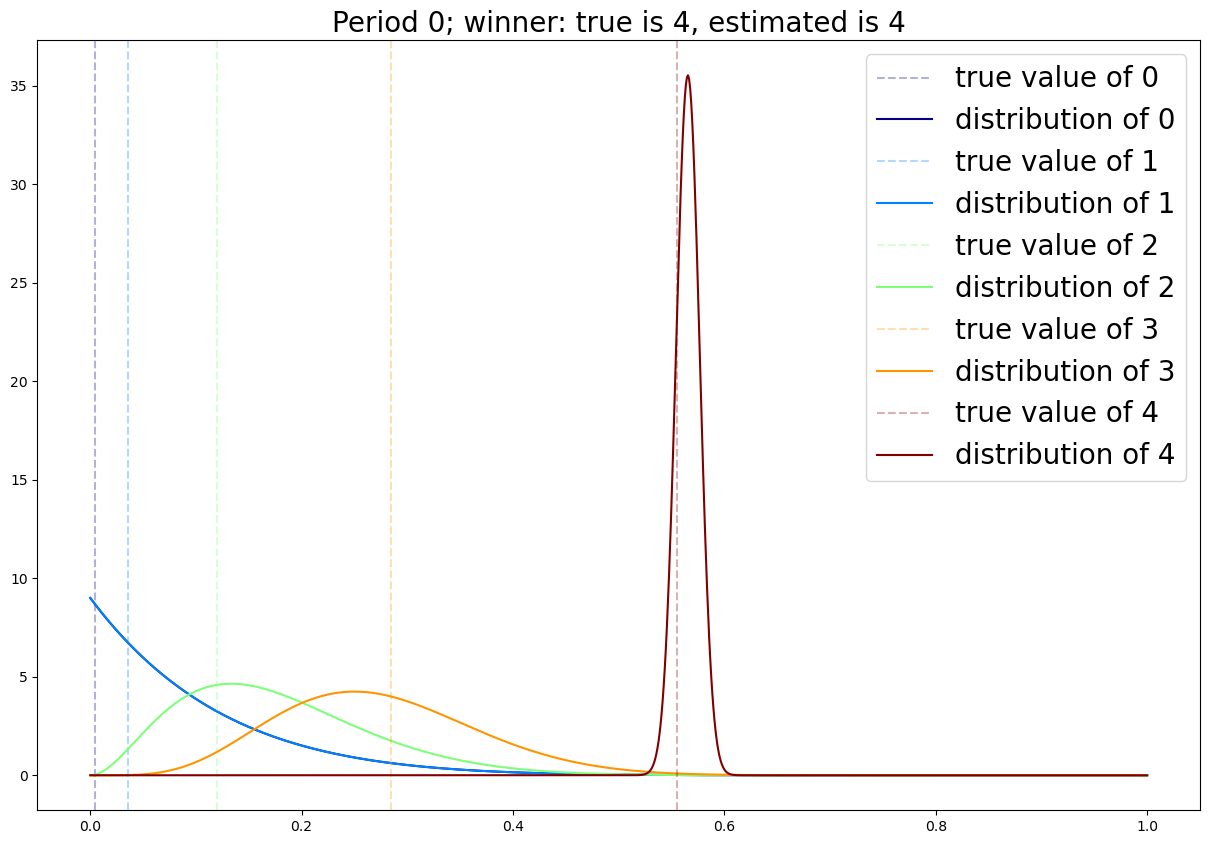

Winner is 1
3    1393
4     581
2      14
1      10
0       2
Name: count, dtype: int64


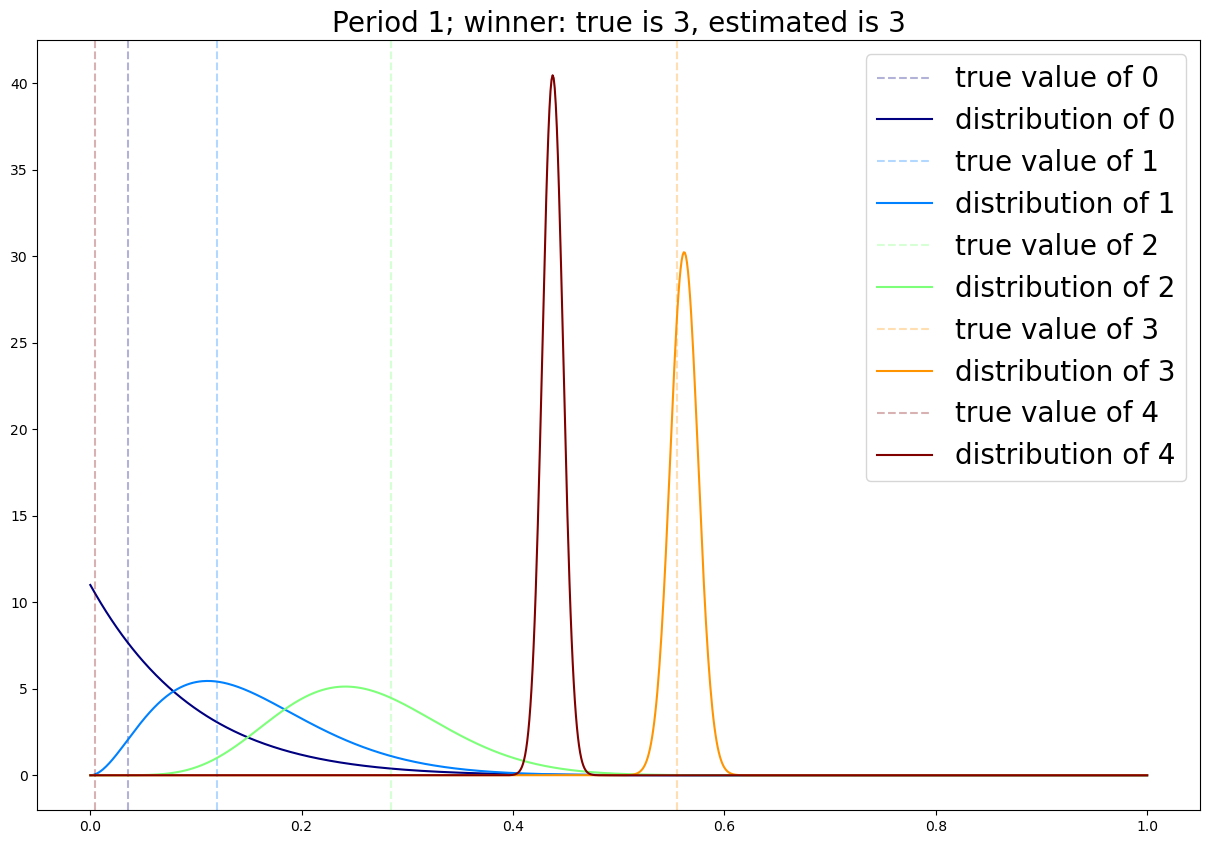

Winner is 2
2    1416
3     497
4      84
1       2
0       1
Name: count, dtype: int64


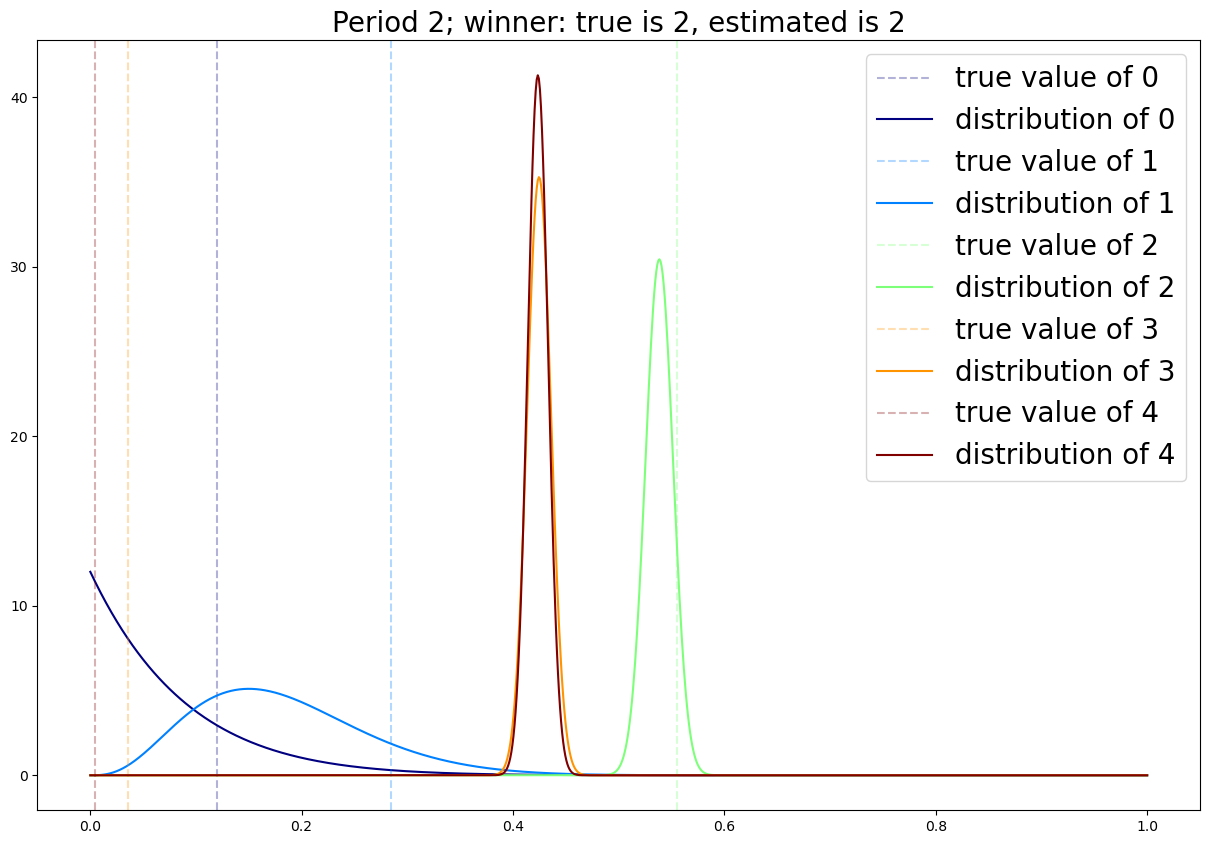

Winner is 3
2    865
1    585
4    293
3    255
0      2
Name: count, dtype: int64


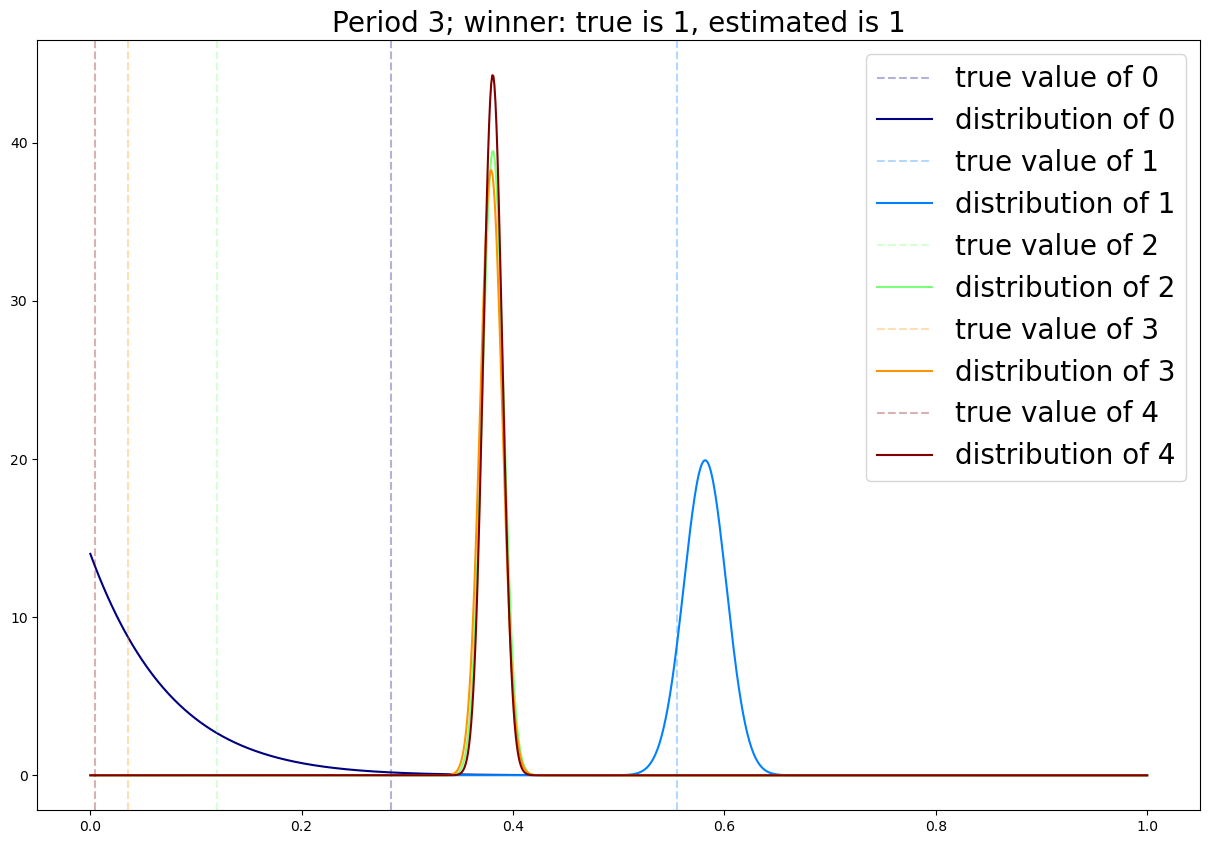

Winner is 4
1    1356
0     277
2     136
4     122
3     109
Name: count, dtype: int64


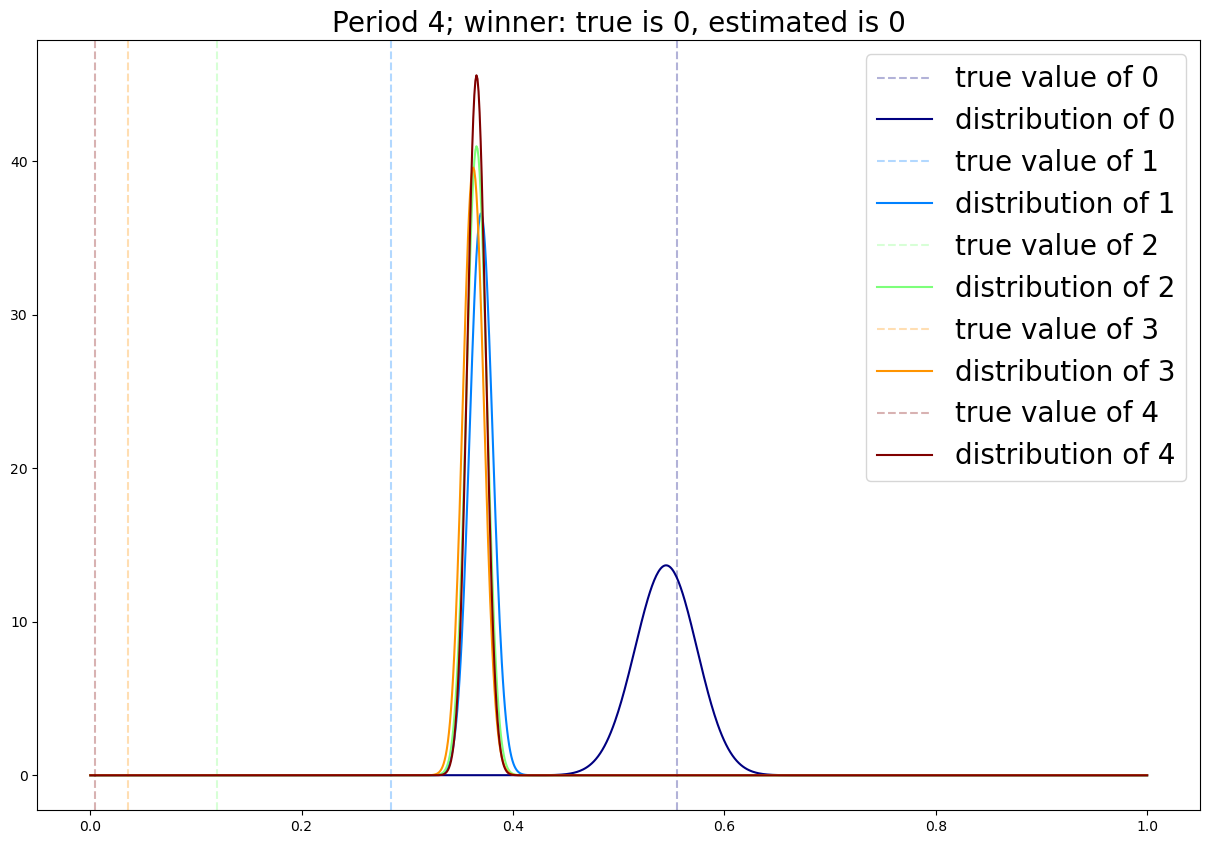

In [ ]:
x_support = np.linspace(0, 1, 1000)

alpha = dict([(i, [1]) for i in range(n_variations)])
beta = dict([(i, [1]) for i in range(n_variations)])

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n_variations)]

actionspp = []

# Перебор периодов
for ix_period in range(p_true_periods.shape[1]):
    p_true = p_true_periods[:, ix_period]
    is_converged = False
    actions = []
    for ix_step in range(n_period_len):
        theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1]))
                     for i in range(n_variations)])
        k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
        actions.append(k)

        x_k = np.random.binomial(1, p_true[k], size=1)[0]

        alpha[k].append(alpha[k][-1] + x_k)
        beta[k].append(beta[k][-1] + 1 - x_k)
    expected_reward = dict([(i, alpha[i][-1] / float(alpha[i][-1] + beta[i][-1]))
                           for i in range(n_variations)])
    estimated_winner = sorted(expected_reward.items(),
                             key=lambda t: t[1],
                             reverse=True)[0][0]

    print(f'Winner is {ix_period}')
    actions_loc = pd.Series(actions).value_counts()
    print(actions_loc)
    actionspp.append(actions_loc.to_dict())

    plt.figure(figsize=(15, 10))
    for i in range(n_variations):
        plt.axvline(x=p_true[i], color=colors[i], linestyle='--',
                   alpha=0.3, label=f'true value of {i}')

        plt.plot(x_support, sps.beta.pdf(x_support, alpha[i][-1], beta[i][-1]),
                label=f'distribution of {i}', color=colors[i])
    plt.legend(prop={'size': 20})
    plt.title(f'Period {ix_period}; winner: true is {p_true.argmax()}, estimated is {estimated_winner}', fontsize=20)
    plt.show()

actionspp = dict(enumerate(actionspp))


Отрисуем долю трафика, потраченного на каждую вариацию в каждый период

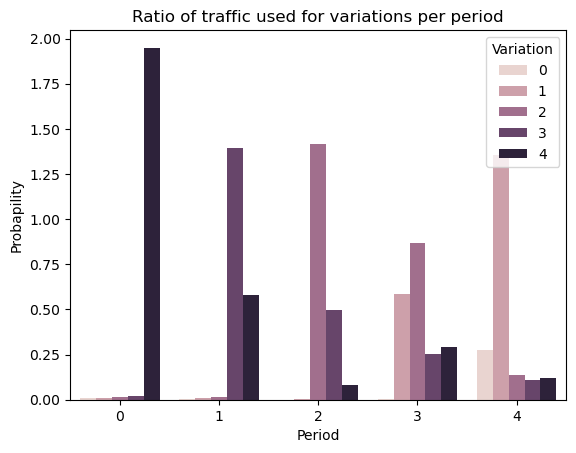

In [ ]:
df = []
for pid in actionspp.keys():
    for vid in actionspp[pid].keys():
        df.append({
            'Period': pid,
            'Variation': vid,
            'Probapility': actionspp[pid][vid]/1000.0
        })
df = pd.DataFrame(df)
ax = sns.barplot(x="Period", y="Probapility", hue="Variation", data=df)
ax.set(title="Ratio of traffic used for variations per period")
plt.show()